In [ ]:
import glob
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
lst_crack_img = glob.glob('/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00*.jpg')
lst_non_crack_img = glob.glob('/content/drive/MyDrive/Datasets/road_crack_dataset/Negative/00*.jpg')

In [ ]:
lst_crack_img

['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00590.jpg',
 '/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00704.jpg',
 '/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00243.jpg',
 '/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00153.jpg',
 '/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00710.jpg',
 '/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00390.jpg',
 '/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00902.jpg',
 '/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00392.jpg',
 '/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00448.jpg',
 '/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00528.jpg',
 '/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00705.jpg',
 '/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00622.jpg',
 '/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00621.jpg',
 '/content/drive/MyDrive/Datasets/road

In [ ]:
lst_crack = []
for x in lst_crack_img:
    lst_crack.append([x,1])
lst_nn_crack = []
for x in lst_non_crack_img:
    lst_nn_crack.append([x,0])
lst_complete = lst_crack + lst_nn_crack
random.shuffle(lst_complete)

In [ ]:
lst_crack

[['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00590.jpg', 1],
 ['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00704.jpg', 1],
 ['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00243.jpg', 1],
 ['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00153.jpg', 1],
 ['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00710.jpg', 1],
 ['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00390.jpg', 1],
 ['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00902.jpg', 1],
 ['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00392.jpg', 1],
 ['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00448.jpg', 1],
 ['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00528.jpg', 1],
 ['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00705.jpg', 1],
 ['/content/drive/MyDrive/Datasets/road_crack_dataset/Positive/00622.jpg', 1],
 ['/content/drive/MyDrive/Datasets/road_crack_datase

In [ ]:
df = pd.DataFrame(lst_complete,columns = ['files','target'])
df.head(10)

,files,target
0,/content/drive/MyDrive/Datasets/road_crack_dat...,1
1,/content/drive/MyDrive/Datasets/road_crack_dat...,0
2,/content/drive/MyDrive/Datasets/road_crack_dat...,0
3,/content/drive/MyDrive/Datasets/road_crack_dat...,1
4,/content/drive/MyDrive/Datasets/road_crack_dat...,1
5,/content/drive/MyDrive/Datasets/road_crack_dat...,0
6,/content/drive/MyDrive/Datasets/road_crack_dat...,1
7,/content/drive/MyDrive/Datasets/road_crack_dat...,0
8,/content/drive/MyDrive/Datasets/road_crack_dat...,1
9,/content/drive/MyDrive/Datasets/road_crack_dat...,1


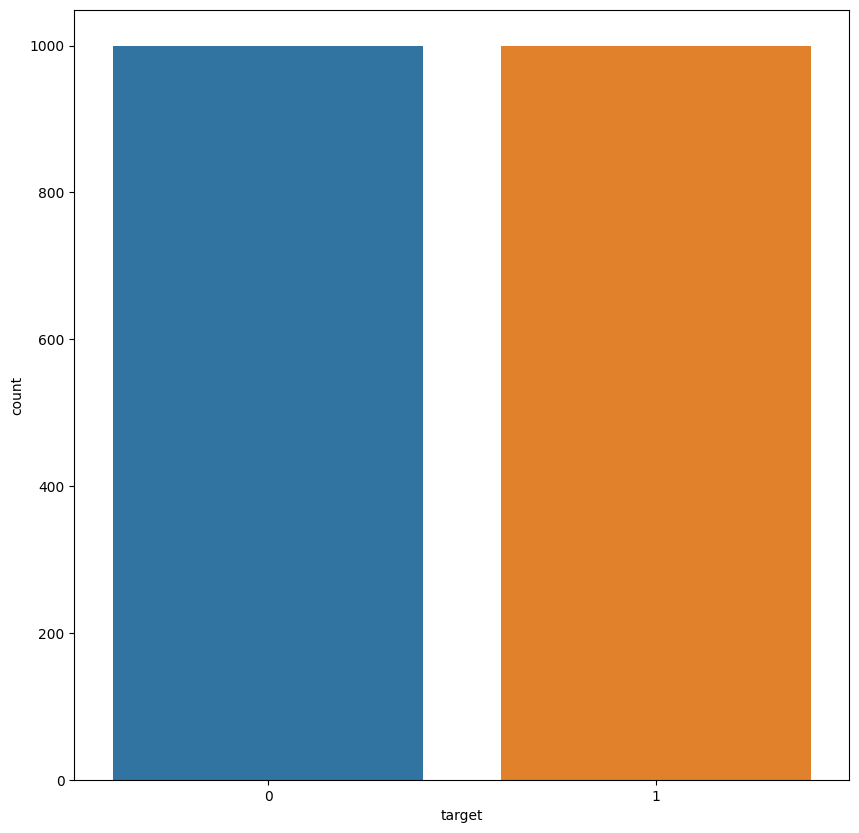

In [ ]:
plt.figure(figsize = (10,10))
sns.countplot(x = "target",data = df)

plt.show()

**We preprocess all the images**

In [ ]:
def preprocessing_image(filepath):
    img = cv2.imread(filepath) #read
    if img is None:
        print("Error: Could not load image")
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) #convert
    img = cv2.resize(img,(227,227))  # resize   #######modified according to the input size
    img = img / 255 #scale
    return img

In [ ]:
def create_format_dataset(dataframe):
    X = []
    y = []
    i=0
    for f,t in dataframe.values:
        i+=1
        print(i)
        X.append(preprocessing_image(f))
        y.append(t)

    return np.array(X),np.array(y)

In [ ]:
X, y = create_format_dataset(df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
print(X.shape)
print(y.shape)

(1998, 227, 227, 3)
(1998,)


**We split the data in train and test**

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify = y)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1398, 227, 227, 3), (600, 227, 227, 3), (1398,), (600,))

In [ ]:
"""
model = Sequential()

model.add(Conv2D(2,(1,1),input_shape = (227,227,3),activation='relu')) #227,227,2
model.add(MaxPooling2D()) #113,113,2
model.add(Conv2D(4,(1,1),activation='relu')) #113,113,4
model.add(MaxPooling2D()) #56,56,4
model.add(Conv2D(8,(1,1),activation='relu')) #56,56,8
model.add(MaxPooling2D()) #28,28,8
model.add(Conv2D(16,(1,1),activation='relu')) #28,28,16
model.add(MaxPooling2D()) #14,14,16
model.add(Conv2D(32,(1,1),activation='relu')) #14,14,32
model.add(MaxPooling2D()) #7,7,32
model.add(Conv2D(64,(1,1),activation='relu')) #7,7,64
model.add(MaxPooling2D()) #3,3,64
model.add(Conv2D(128,(1,1),activation='relu')) #3,3,128

model.add(Flatten())
model.add(Dense(2, activation = 'softmax')) # 1,1,2
"""

In [ ]:
inputs = tf.keras.layers.Input(shape=(227, 227, 3))

x = Conv2D(2, (1, 1))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(4, (1, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(8, (1, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(16, (1, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(32, (1, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(64, (1, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (1, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 2)       8         
                                                                 
 batch_normalization (BatchN  (None, 227, 227, 2)      8         
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 227, 227, 2)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 2)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 113, 113, 4)       12    

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 10,restore_best_weights=True)]

In [ ]:
model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 30,batch_size = 32,callbacks = callbacks)

Epoch 1/30
44/44 [==============================] - 20s 75ms/step - loss: 0.4033 - accuracy: 0.8183 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 2/30
44/44 [==============================] - 1s 26ms/step - loss: 0.3319 - accuracy: 0.8526 - val_loss: 0.6983 - val_accuracy: 0.5000
Epoch 3/30
44/44 [==============================] - 1s 26ms/step - loss: 0.3107 - accuracy: 0.8677 - val_loss: 0.6979 - val_accuracy: 0.5000
Epoch 4/30
44/44 [==============================] - 1s 26ms/step - loss: 0.2961 - accuracy: 0.8712 - val_loss: 0.7078 - val_accuracy: 0.5000
Epoch 5/30
44/44 [==============================] - 1s 26ms/step - loss: 0.2909 - accuracy: 0.8677 - val_loss: 0.6675 - val_accuracy: 0.5217
Epoch 6/30
44/44 [==============================] - 2s 44ms/step - loss: 0.2793 - accuracy: 0.8670 - val_loss: 0.6048 - val_accuracy: 0.6750
Epoch 7/30
44/44 [==============================] - 2s 45ms/step - loss: 0.2759 - accuracy: 0.8805 - val_loss: 0.5042 - val_accuracy: 0.7683
Epoch 8/30
4

In [ ]:
y_pred = model.predict(X_test)

19/19 [==============================] - 0s 13ms/step


In [ ]:
y_pred

array([[0.08731471],
       [0.02582877],
       [0.6016684 ],
       [0.0161129 ],
       [0.03544603],
       [0.44690087],
       [0.9998305 ],
       [0.16539325],
       [0.19282325],
       [0.23288198],
       [0.9991283 ],
       [0.42233974],
       [0.9945029 ],
       [0.36318216],
       [0.71572137],
       [0.37486792],
       [0.13528271],
       [0.24303013],
       [0.99999917],
       [0.2237627 ],
       [0.06632553],
       [0.6803757 ],
       [0.99981076],
       [0.5800899 ],
       [0.21755551],
       [0.9993486 ],
       [0.09485965],
       [0.01534599],
       [0.02334704],
       [0.99474794],
       [0.99999905],
       [0.42753357],
       [0.01398538],
       [0.999858  ],
       [0.92721236],
       [0.9995759 ],
       [0.3885994 ],
       [0.9999583 ],
       [0.5275006 ],
       [0.28668472],
       [0.09878473],
       [0.99996233],
       [0.9989146 ],
       [0.08906463],
       [0.8170035 ],
       [0.9995913 ],
       [0.00770289],
       [0.280

In [ ]:
y_pred = y_pred > 0.5

In [ ]:
y_pred

array([[False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [

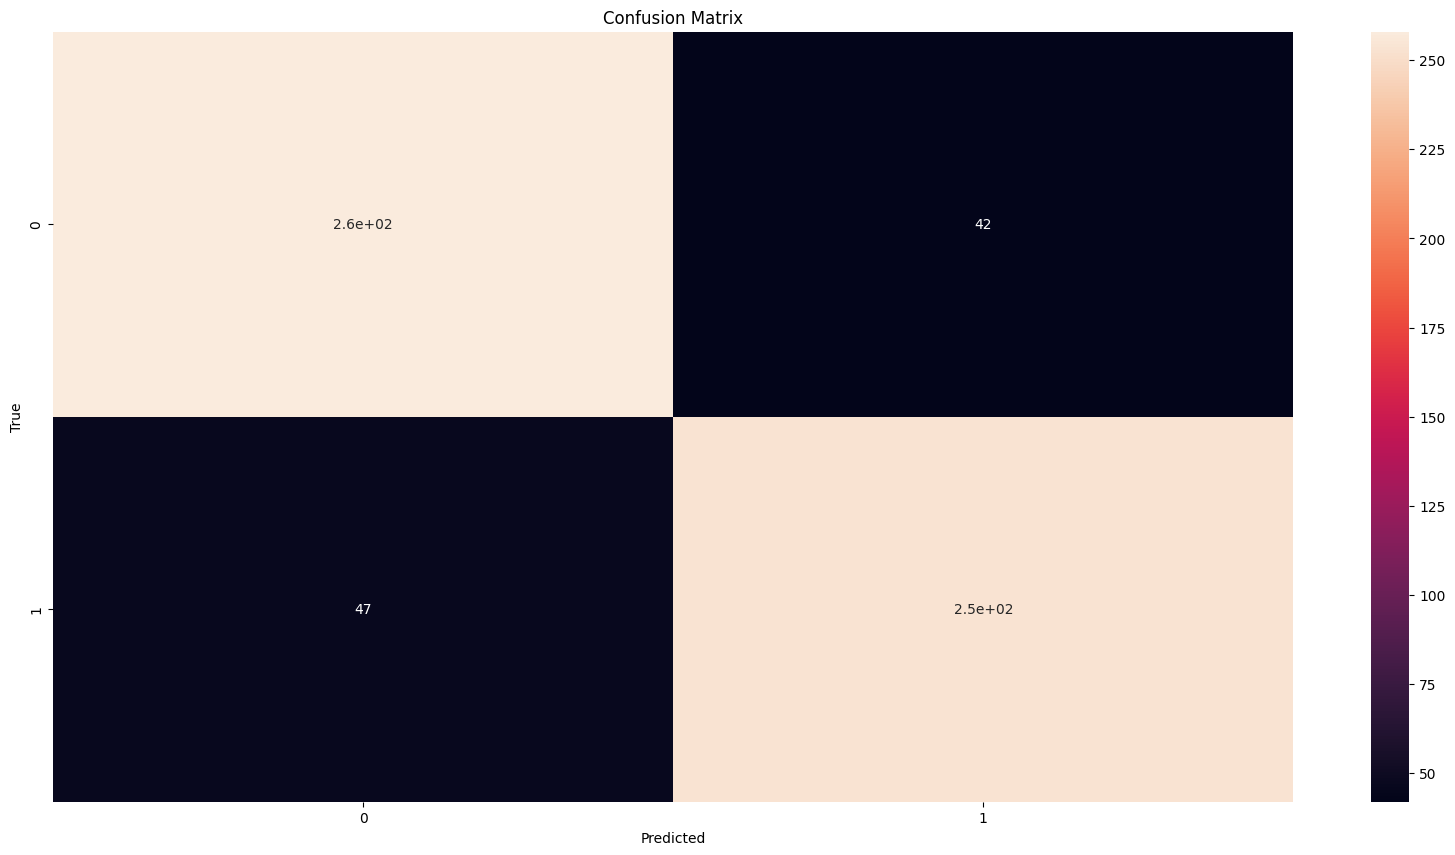

In [ ]:
plt.figure(figsize = (20,10))

sns.heatmap(confusion_matrix(y_test,y_pred),annot = True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       300
           1       0.86      0.84      0.85       300

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



In [ ]:
import os.path

In [ ]:
if os.path.isfile('/content/drive/MyDrive/Saved Models/Road_Crack_Detection_Model_2000.h5') is False:
    model.save('/content/drive/MyDrive/Saved Models/Road_Crack_Detection_Model_2000.h5')